# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [conclusion](#conclusion)
- [resources](#resources)


<a id='intro'></a>
## Introduction

We will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<center>
    
|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|

</center>

In [1]:
#import packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
# Fixing random seed for reproducibility
np.random.seed(42)

In [2]:
#set palette for visualization
sns.set()
sns.set_theme(style="darkgrid",palette="deep")

In [3]:
#loading ab data 
data = pd.read_csv("ab_data.csv",parse_dates = ['timestamp'])

In [4]:
#make new copy of dataframe and print out a few lines of data
df = data.copy()
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
#info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [6]:
#the number of rows in the dataset
rows_num = df.shape[0]
print(f'the number of rows in the dataset are : {rows_num}')

the number of rows in the dataset are : 294478


In [7]:
#The number of unique users
users_num = df['user_id'].nunique()
print(f'The number of unique users is : {users_num}')

The number of unique users is : 290584


In [8]:
#The proportion of users converted
converted_prop = df["converted"].mean()
print(f"The proportion of users converted is : {converted_prop} ")

The proportion of users converted is : 0.11965919355605512 


In [9]:
#The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`
unmatched_data = df.query('(group == "treatment") != (landing_page == "new_page")')
print(f"The number of times when the 'group' is treatment but 'landing_page' is not a new_page is :{unmatched_data.shape[0]}")

The number of times when the 'group' is treatment but 'landing_page' is not a new_page is :3893


In [10]:
#show unacceptable data
unmatched_data.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page so we will drop it.

In [11]:
df.isnull().any().sum()

0

No missing data

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

In [12]:
# Remove the unacceptable rows, and store the result in a new dataframe df2
df2 = df.drop(unmatched_data.index,axis=0)

In [13]:
# Double Check all of the unacceptable rows were removed from df2 
df2.query('(group == "treatment") != (landing_page == "new_page")').shape[0]

0

In [14]:
#number of unique users in df2
df2["user_id"].nunique()

290584

In [15]:
#duplicated users
repeated_user = df2[df2["user_id"].duplicated()]
repeated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
#the rows for the duplicates
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# Remove one of the rows with a duplicate user_id..
df2.drop(repeated_user.index,axis=0,inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2["user_id"].duplicated().any()

False

#### Duration of A/B Test

In [18]:
df2['timestamp'].max()-df2['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

##### this ab test run for 21 days

<a id='probability'></a>
## Part I - Probability

In [19]:
#the probability that an individual received the new page
(df2['landing_page'] == "new_page").mean()

0.5000619442226688

In [20]:
#the probability that an individual received the old page
(df2['landing_page'] == "old_page").mean()

0.4999380557773312

In [21]:
#the probability of an individual converting regardless of the page they receive
Ppopulation = df2["converted"].mean()
print(f"the probability of an individual converting : {Ppopulation} ")

the probability of an individual converting : 0.11959708724499628 


In [22]:
#divide the data to two groups
control_gp = df2.query('group == "control"')
treatment_gp = df2.query('group == "treatment"')

In [23]:
#the probability of an individual was in the control group and converting 
#conversion rate for control group
cov_control_gp = control_gp['converted'].mean()
print(f"the conversion rate for control group is : {cov_control_gp} ")

the conversion rate for control group is : 0.1203863045004612 


In [24]:
#the probability of an individual was in the treatment group and converting
#conversion rate for treatment group
cov_treatment_gp = treatment_gp['converted'].mean()
print(f"the conversion rate for treatment group is : {cov_treatment_gp} ")

the conversion rate for treatment group is : 0.11880806551510564 


In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = cov_treatment_gp - cov_control_gp
obs_diff

-0.0015782389853555567

#### the conversion rate for the old page is slightly higher than that of the new page

>**There is nearly an equal probability that an individual received the new page or old page with no sufficient evidence to say that the new treatment page leads to more conversions..**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


based on all the data provided.  

> **the conversion rate for the old page (cov_control_gp) is slightly higher than the conversion rate for new page (cov_treatment_gp).** 

So We will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

$$H_0: \ p_{new} - \ p_{old} \leq  0$$


$$H_1: \ p_{new} - \ p_{old} > 0$$


**$p_{old}$** and **$p_{new}$ are the probability for the old and new pages respectively.**

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center> 

In this section, We will

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate.

In [26]:
#the conversion rate for 𝑛𝑒𝑤 page under the null hypothesis
p_new = df2[df2['landing_page']== 'new_page']['converted'].mean()
p_new

0.11880806551510564

In [27]:
#the conversion rate for old page under the null hypothesis
p_old = df2[df2['landing_page']== 'old_page']['converted'].mean()
p_old

0.1203863045004612

In [28]:
#the number of individuals in the treatment group
n_new = treatment_gp.shape[0]
n_new

145310

In [29]:
#the number of individuals in the control group
n_old = control_gp.shape[0]
n_old

145274

In [30]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(treatment_gp['converted'],n_new, p_new)
new_page_converted

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [31]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(control_gp['converted'],n_old, p_old)
old_page_converted

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [32]:
#the difference in the probability  (𝑝′𝑛𝑒𝑤  -  𝑝′𝑜𝑙𝑑)  for the simulated samples
new_page_converted.mean() - old_page_converted.mean()

-0.004544659415804939

In [33]:
# Sampling distribution for 2 pages
sample_old_pg = np.random.binomial(n_old,p_old,10000)/ n_old  
sample_new_pg = np.random.binomial(n_new,p_new,10000)/ n_new
p_diffs = []
p_diffs.append(sample_new_pg - sample_old_pg)

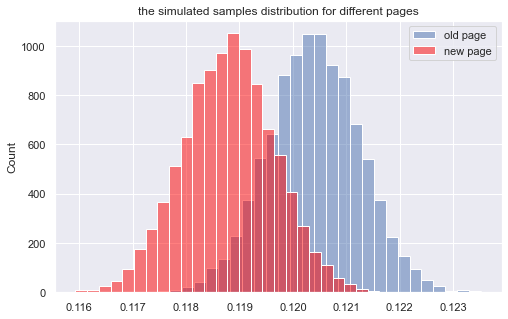

In [34]:
fig, ax1 =plt.subplots(1,figsize=(8,5))
sns.histplot(x=sample_old_pg, bins=30,alpha = 0.5,label= 'old page' ,ax=ax1);
sns.histplot(x=sample_new_pg, bins=30,alpha = 0.5,label= 'new page',color ='red',ax=ax1);
ax1.set_title('the simulated samples distribution for different pages');
ax1.legend();

**they look pretty normally distributed**

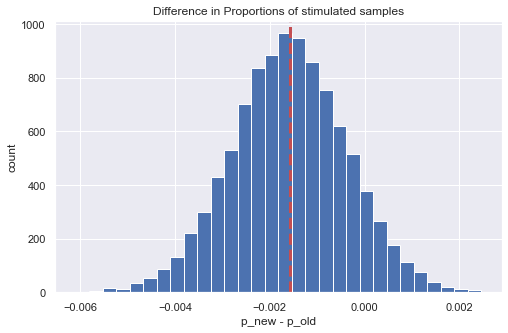

In [35]:
#Plot a histogram of the p_diffs.
fig, ax1 =plt.subplots(1,figsize=(8,5))
plt.hist(x=p_diffs, bins=30)
plt.title('Difference in Proportions of stimulated samples');
plt.axvline(obs_diff,color ='r',linestyle='--',linewidth = 3);
plt.xlabel('p_new - p_old');
plt.ylabel('count');

**it looks pretty normally distributed**

In [36]:
#stimulate sampling under null hypothesis
null_val = np.random.normal(0,np.std(p_diffs), (np.array(p_diffs)).size)

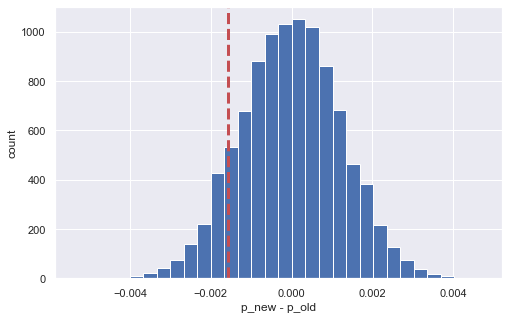

In [37]:
#plot null distribution
plt.figure(figsize=(8, 5))
plt.hist(null_val,bins=30);
plt.axvline(obs_diff,color ='r',linestyle='--',linewidth = 3);
plt.xlabel('p_new - p_old');
plt.ylabel('count');

In [38]:
#the proportion of the p_diffs are greater than the actual difference observed in the data
p_value = (null_val > obs_diff).mean()
p_value

0.8947

In [39]:
p_value <= 0.05

False

In [40]:
# Confidence interval 95% for right-Tailed Hypothesis Tests
upper_bound = np.percentile(null_val,95)
upper_bound

0.002007893634235566

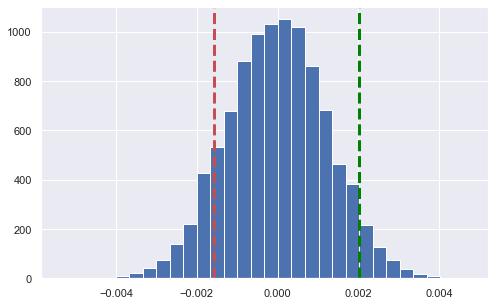

In [41]:
#plot sampling stimulation under null hypothesis
plt.figure(figsize=(8, 5))
plt.hist(null_val,bins=30);
#plot observed statistic (obs_diff)
plt.axvline(obs_diff,color ='r',linestyle='--',linewidth = 3);
#plot Confidence interval 95%
plt.axvline(upper_bound,color ='green',linestyle='--',linewidth = 3);

By comparing our $p_{value}$ to our type I error threshold $\alpha$ , 

### $p_{value} > \alpha $
#### so we Fail to Reject the null hypothesis $H_0$

the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. 
Therefore, we do not have evidence to reject the null 

### the two-sample z-test

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**.


****Using Built-in Methods for Hypothesis Testing*****<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code

Calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [42]:
# number of conversions with the old_page
convert_old = control_gp.query('converted == 1')['converted'].count()

# number of conversions with the new_page
convert_new = treatment_gp.query('converted == 1')['converted'].count()

# number of individuals who were shown the old_page
# number of individuals who received new_page
n_new , n_old

(145310, 145274)

In [43]:
convert_old ,convert_new ,n_old ,n_new

(17489, 17264, 145274, 145310)

In [44]:
#two-sample z-test for rigt tail hypothesis
count_array = np.array([convert_new ,convert_old])
nobs_array = np.array([n_new , n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


In [45]:
# comparing 𝑍𝑠𝑐𝑜𝑟𝑒  and 𝑍𝛼 for right tailed test
z_score > 1.645

False

again  $p_{value}$ as before  $p_{value} > \alpha $ 

and based on comparing  $Z_{score}$ and  $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  
$Z_{0.05}$ = 1.645 for one-tailed tests

### again We fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 

AS $Z_{score}$ < $Z_{\alpha}$. 


In other words, the $Z_{score}$ not lies in the "rejection region" in the distribution. 

<a id='regression'></a>
### Part III - A regression approach

what type of regression should we be performing in this case?

>**We will fit the Logistic regression model\
to predicts categorical responses because there are only two possible outcomes either a conversion or no conversion.**

Our goal to see if there is a significant difference in conversion based on the page-type a customer receives.

In [46]:
#create ab_page column for encoding landing page
df2['ab_page'] = np.select([df2['group']=="treatment" , df2['group']=="control"],[1,0])

In [47]:
#create intercept column
df2['intercept'] = 1

In [48]:
# fit logistic regression model
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [49]:
#summarize the result of model
print(results.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-02-19 20:56 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



In [50]:
# the p-value associated with ab_page
results.pvalues[1]

0.1898862112362789

In [51]:
results.pvalues[1] < 0.05

False

- as hypothesis associated with the regression model is two-sided but previously was one-sided
- $p_{value}$ associated with **ab_page** is different from before but still larger than $\alpha$
### so again We fail to reject the null
there is **no** a significant difference in conversion based on the page-type a customer receives.
AS the landing page Not have statistically significant relationships with a customer being converted.

### **Now, We are considering other things that might influence whether or not an individual converts.**  

this can represent a barrier to testing a particular hypothesis, it is also an opportunity to dissect the many determinants and to define their relative importance.

the disadvantages to adding additional terms into  regression model
- confounding phenomenon As the results obtained using one predictor may be quite different from those obtained using multiple predictors, especially when there is correlation among the predictors 
- logistic regression is not able to handle a large number of categorical variables. It is vulnerable to overfitting. 


**Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.** 

In [52]:
# Read the countries data
countries = pd.read_csv('countries.csv')

In [53]:
#the number of customer in every country
countries['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [54]:
# Join countries with the df2 dataframe
df_merged = pd.merge(df2,countries,on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [55]:
#the propabilitly of convertion for every country
df_merged.groupby('country')['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [56]:
df_merged = pd.get_dummies(data = df_merged ,columns=['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country_CA,country_UK,country_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,0,1


**We would now like to look at an interaction between page and country to see if are there significant effects on conversion.**

In [57]:
# Fit multiple logistic regression model
ml = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page','country_UK','country_US']])
result2 = ml.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [58]:
#summarize the result of model
print(result2.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-02-19 20:56 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
country_UK     0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
country_US     

>**based on the results.**: 

- When We Look at all of p-values in the summary, and compare against Type I error rate ($\alpha$) find it greater than 0.05 . 
- So again and again We fail to reject the null hypothesis (regression model)
- page and country Not have significant effects on conversion.

<a id='conclusion'></a>
## conclusion

>**Finally  based on the data we fail to reject the null hypothesis so advice the company to Keep the old webpage .**

<a id='resources'></a>
## resources

- pandas
- stackoverflow
- StatQuest with Josh Starmer
- Introduction to Statistical Learning[book]
- datacamp